In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
states = np.zeros((9,7))
states[1,1:3] = 1
states[1,3] = 2 
states[1,4:6] = 1
states[2,1] = 1
states[2,4] = 1
states[3,1:6] = 1
states[4,1] = 1
states[4,5] = 1
states[5,1:6] = 1
states[6,1] = 1
states[6,4] = 1
states[7,1:6] = 1
states[7,5] = 3 
rewards = np.zeros((9,7))
rewards[1,3] = 0
gamma = 0.9
rewards[(1,2)]


0.0

In [79]:
mdp = MDP(rewards,states)

In [80]:
def convert_q_to_grid(q):
    initial_state = list(q)[0][0]
    grid = np.zeros((9,7))
    maximum = -1
    for (state,action) in q:
        if(initial_state != state):
            grid[initial_state] = maximum
            initial_state = state
            maximum = -1

        if(q[(state,action)] > maximum):
            maximum = q[(state,action)]

    return grid

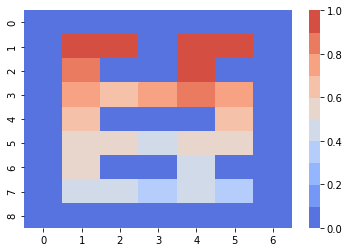

In [72]:
mdp = MDP(rewards,states)
q = mdp.value_iteration(0.9)
graph = convert_q_to_grid(q)
ax = sns.heatmap(graph, linewidth=0.00, cmap=sns.color_palette("coolwarm", 10))
plt.show()
    

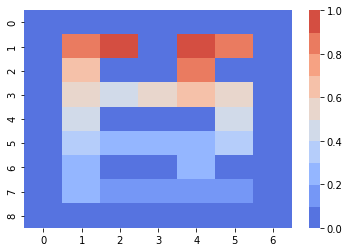

In [76]:
q_l = mdp.q_learning(0.8,0.8,0.5)
graph = convert_q_to_grid(q_l)
ax = sns.heatmap(graph, linewidth=0.00, cmap=sns.color_palette("coolwarm", 10))
plt.show()

In [70]:
class MDP:
    
    FINAL = 2
    START = 3
    OBSTACLE = 0
    FREE = 1
    X_DIMENSION = 7
    Y_DIMENSION = 9
    final_action = "exit"
    actions = ["up","down","right","left","exit"]
    Q_star = {}
    
    def __init__(self, rewards, states):
        self.rewards = rewards
        self.states = states
    
    
    
    def value_iteration(self, gamma):
        Qn = self.initialize_q(self.states)
        Qn_1 = self.initialize_q(self.states)
        grid = self.get_grid_states()
        for n in range(10):
            
            for s in grid:
                possible_actions = self.get_possible_actions(s)
                for a in possible_actions:
                    #with probability 1 goes to s_prime
                    s_prime = self.do_action(a,s)
                    a_primes = self.get_possible_actions(s_prime)
                    #select MAX Qn
                    maximum, max_a_prime = self.select_max_action(a_primes,s_prime,Qn)
        
                            
                    #Case specific rewards
                    r = self.reward(a,s_prime, s)
                    if(a == self.final_action):
                        Qn_1[s,a] = r
                    else:
                        Qn_1[s,a] = r + gamma * maximum
                        
                    Qn = Qn_1
                    
        self.Q_star = Qn
        return self.Q_star
    
    
    
    
    
    def q_learning(self, alpha, gamma, epsilon):
        Qn = self.initialize_q(self.states)
        Qn_1 = self.initialize_q(self.states)
        for n in range(12000):        
            s = (7,5)
            while True:
                possible_actions = self.get_possible_actions(s)
                max_q, max_a = self.select_max_action(possible_actions,s,Qn)  
                max_a = self.exploration_function(max_a, epsilon, s)
                
                s_prime = self.do_action(max_a,s)
                
                a_primes = self.get_possible_actions(s_prime)
                #select MAX Qn
                max_qprime, max_a_prime = self.select_max_action(a_primes,s_prime,Qn)
                
                #Case specific rewards
                r = self.reward(max_a,s_prime, s)
                if(max_a == self.final_action):
                    Qn_1[s,max_a] = r
                    break
                else:
                    Qn_1[s,max_a] = Qn[s,max_a] + alpha* (r + (gamma * max_qprime) - max_q)
                    s = s_prime
                Qn = Qn_1
                    
        self.Q_star_learning = Qn
        return self.Q_star_learning
    
    
    def exploration_function(self, action, epsilon, state):
        if(self.states[state] == 2):
            return "exit"
        else:        
            random_number = np.random.uniform()
            actions = self.get_possible_actions(state)
            if(random_number <= epsilon):
                index = np.random.choice(len(actions), 1, replace=False)  
                return actions[index[0]]
            else:
                return action
            

    def select_max_action(self,actions, state, Q):
        maximum = -1
        best_action = actions[0]
        for action in actions:
            if(Q[state, action] > maximum):
                maximum = Q[state, action]
                best_action = action
        return [maximum, best_action]
    
    
    
    def reward(self,action, next_state, current_state):
        if( (action == "left" and self.states[next_state] == self.FINAL) or (action == "right" and self.states[next_state] == self.FINAL) ):
            return 1
        else:
            return 0
        
    def get_grid_states(self):
        grid = {}
        for i in range(self.Y_DIMENSION):
            for j in range(self.X_DIMENSION):
                    grid[(i,j)]=states[i,j]
        return grid
    
    def get_possible_actions(self, state):
        y = state[0]
        x = state[1]
        actions = []
        if len(state)!=2:
            raise Exception('The state needs to be a tuple')
        if(state[0] >= self.Y_DIMENSION or  state[1] >= self.X_DIMENSION):
            raise Exception('The dimensions are bigger than they should')
        if(self.states[y , x] == self.OBSTACLE):
            return []
            
        if(self.states[state] == self.FINAL):
            return [self.final_action]
        if(y > 0 and self.states[y - 1, x] != self.OBSTACLE):
            #can move up
            actions.append('up')
            
        if(y < self.Y_DIMENSION and self.states[y + 1 , x] != self.OBSTACLE):
            #can move down
            actions.append('down')
            
        if(x < self.X_DIMENSION and self.states[y , x + 1] != self.OBSTACLE):
            #can move right
            actions.append('right')
            
        if(x > 0 and self.states[y , x - 1] != self.OBSTACLE):
            #can move left
            actions.append('left')
        return actions
    
    def initialize_q(self,states):     
        q = {}
        for i in range(self.Y_DIMENSION):
            for j in range(self.X_DIMENSION):
                for action in self.actions:
                    q[(i,j),action]=0
        return q
        
    def do_action(self,action,state):
        y = state[0]
        x = state[1]
        if(action == 'up'):
            return (y - 1,x)
        elif(action == 'right'):
            return (y,x + 1)
        elif(action == 'left'):
            return (y,x - 1)
        elif(action == 'down'):
            return (y + 1,x)
        return (y,x)
    
    

In [17]:
actions=["a","b","c"]
index = np.random.choice(len(actions), 1, replace=False)  
print(actions[index[0]])

a
